In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

from pathlib import Path

import matplotlib.pyplot as plt
import motorlab as ml
import numpy as np
import seaborn as sns
import yaml

In [3]:
os.chdir(Path().resolve().parent)

In [19]:
is_old = True
PREFIX = "old_" if is_old else ""
EXPERIMENT = "old_gbyk" if is_old else "gbyk"
SESSIONS = ml.sessions.OLD_GBYK if is_old else ml.sessions.GBYK
PLOT_DIR = Path("artifacts/plots/predicting_position_from_poses/")
PLOT_DIR.mkdir(parents=True, exist_ok=True)
sns.set_theme(style="whitegrid")

In [5]:
poses = dict()
intervals = dict()

for session in sessions:
    poses_dir = Path("data/gbyk/") / session / "poses"
    poses_ = ml.data.load_from_memmap(poses_dir)
    poses_ = ml.poses.change_representation(
        poses_,
        "centered",
        "gbyk",
    )
    poses[session] = poses_

    intervals[session] = dict()
    intervals_dir = Path(f"data/gbyk/{session}/intervals/")
    for i, meta_interval in enumerate(sorted(intervals_dir.iterdir())):
        intervals[session][i] = {
            "side": None,
            "start": None,
            "end": None,
            "type": None,
        }
        with open(meta_interval, "r") as f:
            meta_dict = yaml.safe_load(f)
            start = int(meta_dict["first_frame_idx"] // 50)
            end = start + int(meta_dict["num_frames"] // 50)
            intervals[session][i]["start"] = start
            intervals[session][i]["end"] = end
            intervals[session][i]["side"] = meta_dict["side"]
            intervals[session][i]["type"] = meta_dict["type"]

In [6]:
test = ml.poses.compute_trunk(poses_, "gbyk")
kps_to_exclude = ["r_eye", "r_ear", "l_eye", "l_ear", "nose", "head", "e_tail"]
idxs = [ml.utils.KEYPOINTS["gbyk"][kp] for kp in kps_to_exclude]
test = test.reshape(-1, 21, 3)
test[:, idxs, :] = np.nan
test = test.reshape(-1, 63)

In [22]:
# old gbyk
runs_uid = {
    "allocentric": "20250807150405",
    "centered": "20250807150231",
    "egocentric": "20250807150107",
    "pc": "20250807145637",
    "loose": "20250807163704",
    "medium": "20250807163553",
    "strict": "20250807163441",
    "draconian": "20250807163328",
    "trunk": "20250807145939",
    "head": "20250807145810",
}

In [17]:
test_intervals, _, _ = ml.intervals.load_all_by_tiers(
    data_dir="data",
    sessions=SESSIONS,
    experiment=EXPERIMENT,
    include_trial=True,
    include_homing=False if is_old else True,
    include_sitting=True,
)

/Users/caio/dev/motorlab/motorlab/data.py:88: RuntimeWarning: Mean of empty slice
  mm_data = np.nanmean(mm_data, axis=1)


In [18]:
results_dict = {
    "representation": [],
    "monkey": [],
    "type": [],
    "y_acc": [],
    "x_acc": [],
    "acc": [],
}

for representation, run in runs_uid.items():
    config_path = Path(f"artifacts/config/poses_to_position/{run}.yml")

    with open(config_path, "r") as f:
        config = yaml.safe_load(f)
        config["dataset"]["entire_trials"] = True
        config["dataset"]["batch_size"] = 1

    eval_metrics, eval_gts, eval_preds = ml.model.evaluate(config)

    for session in config["sessions"]:
        assert len(eval_gts[session]["position"]) == len(
            eval_preds[session]["position"]
        ), (
            f"GT and predictions for {session} have different lengths: "
            f"{len(eval_gts[session]['position'])} vs {len(eval_preds[session]['position'])}"
        )
        assert len(test_intervals[session]) == len(
            eval_gts[session]["position"]
        ), (
            f"Intervals for {session} have different lengths than GT: "
            f"{len(test_intervals[session])} vs {len(eval_gts[session]['position'])}"
        )
        for i in range(len(test_intervals[session])):
            gt = ml.room.get_tiles(
                eval_gts[session]["position"][i][:, 0],
                eval_gts[session]["position"][i][:, 1],
            )
            pred = ml.room.get_tiles(
                eval_preds[session]["position"][i][:, 0],
                eval_preds[session]["position"][i][:, 1],
            )
            acc = ml.metrics.balanced_accuracy(gt, pred)
            results_dict["acc"].append(acc)
            results_dict["x_acc"].append(
                ml.metrics.balanced_accuracy(gt, pred, group_by="x")
            )
            results_dict["y_acc"].append(
                ml.metrics.balanced_accuracy(
                    gt, pred, group_by="y", include_sitting=False
                )
            )
            results_dict["representation"].append(representation)
            results_dict["monkey"].append(session[:3])
            results_dict["type"].append(test_intervals[session][i].type)

/Users/caio/dev/motorlab/motorlab/data.py:88: RuntimeWarning: Mean of empty slice
  mm_data = np.nanmean(mm_data, axis=1)
/Users/caio/dev/motorlab/motorlab/data.py:88: RuntimeWarning: Mean of empty slice
  mm_data = np.nanmean(mm_data, axis=1)
/Users/caio/dev/motorlab/motorlab/data.py:88: RuntimeWarning: Mean of empty slice
  mm_data = np.nanmean(mm_data, axis=1)
/Users/caio/dev/motorlab/motorlab/data.py:88: RuntimeWarning: Mean of empty slice
  mm_data = np.nanmean(mm_data, axis=1)
/Users/caio/dev/motorlab/motorlab/data.py:88: RuntimeWarning: Mean of empty slice
  mm_data = np.nanmean(mm_data, axis=1)
/Users/caio/dev/motorlab/motorlab/data.py:88: RuntimeWarning: Mean of empty slice
  mm_data = np.nanmean(mm_data, axis=1)
/Users/caio/dev/motorlab/motorlab/data.py:88: RuntimeWarning: Mean of empty slice
  mm_data = np.nanmean(mm_data, axis=1)
/Users/caio/dev/motorlab/motorlab/data.py:88: RuntimeWarning: Mean of empty slice
  mm_data = np.nanmean(mm_data, axis=1)
/Users/caio/dev/motorlab

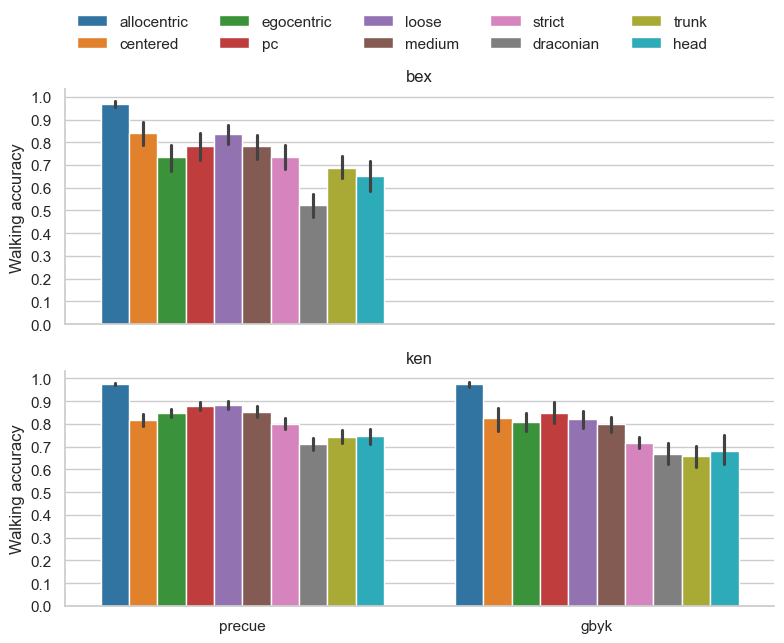

In [23]:
g = sns.catplot(
    data=results_dict,
    col="monkey",
    x="type",
    y="y_acc",
    hue="representation",
    kind="bar",
    col_wrap=1,
    hue_order=list(runs_uid.keys()),
    palette="tab10",
)

g.set(yticks=np.arange(0, 1.1, 0.1))
g.fig.set_size_inches(8, 6)
legend = g._legend
handles = legend.legend_handles
labels = [t.get_text() for t in legend.get_texts()]
legend.remove()
g.fig.legend(
    handles,
    labels,
    bbox_to_anchor=(0.5, 1.03),
    loc="center",
    frameon=False,
    ncol=5,
    title="",
)
g.set_axis_labels("", "Walking accuracy")

for ax, title in zip(g.axes.flat, g.col_names):
    ax.set_title(title)

plt.tight_layout()
plt.savefig(
    PLOT_DIR / f"{PREFIX}barplot_walking_accuracy.svg", bbox_inches="tight"
)
plt.show()

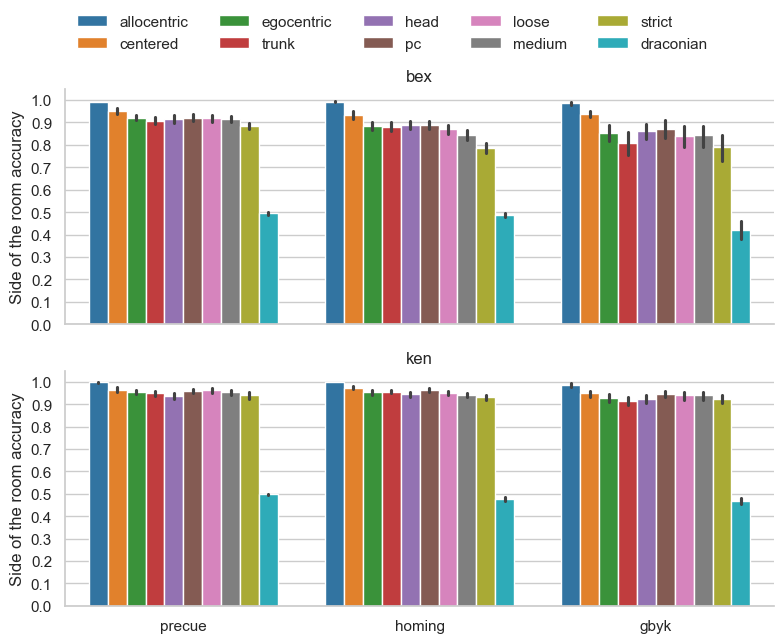

In [ ]:
g = sns.catplot(
    data=results_dict,
    col="monkey",
    x="type",
    y="x_acc",
    hue="representation",
    kind="bar",
    col_wrap=1,
    hue_order=list(runs.keys()),
    palette="tab10",
)

g.set(yticks=np.arange(0, 1.1, 0.1))
g.fig.set_size_inches(8, 6)
legend = g._legend
handles = legend.legend_handles
labels = [t.get_text() for t in legend.get_texts()]
legend.remove()
g.fig.legend(
    handles,
    labels,
    bbox_to_anchor=(0.5, 1.03),
    loc="center",
    frameon=False,
    ncol=5,
    title="",
)
g.set_axis_labels("", "Side of the room accuracy")

for ax, title in zip(g.axes.flat, g.col_names):
    ax.set_title(title)

plt.tight_layout()
plt.savefig(
    PLOT_DIR / f"{PREFIX}barplot_side_accuracy.svg", bbox_inches="tight"
)
plt.show()